In [1]:
import os
import h5py
import gvar   as gv
import numpy  as np
import pandas as pd
from   matplotlib import pyplot as plt

def RatioFileString(name,ts,h,hss,q,l,p):
    return f'{name}T{ts}{h}_RW_{hss}_rot_rot{q}{l}_p{p}'

def format(v):
    return gv.gvar(
        v.mean(axis=0),
        v.std(axis=0) * np.sqrt(v.shape[0]-1)
    )

def plot(v):
    plt.errorbar(
        np.arange(len(v)),
        gv.mean(v),
        gv.sdev(v),
        fmt='.'
    )

def jkCorr(data, bsize=1):
    if bsize==0:
        return data
    else:
        rData = (data.shape[0]//bsize)
        nData = rData*bsize
        dIn   = data[0:nData,:]

        avg   = dIn.mean(axis=0)

        base  = dIn.sum(axis=0) # avg * nData

        dOut  = dIn * 0.0

        for cf in range(rData):
            pvg = dIn[cf*bsize:(cf+1)*bsize,:].sum(axis=0)
            dOut[cf,:] = (base - pvg)/(nData - bsize)

        return dOut[:rData,:]

In the following cell import `FnalHISQMetadata` module giving the correct path

In [2]:
from b2heavy.FnalHISQMetadata import params # change

ens = 'Coarse-1'
mom = '300'
jk  = 11

mdata = params(ens)
Ta,Tb = mdata['hSinks']

heavy = '_k' + mdata['kBStr']
light = '_k' + mdata['kDStr']
qq    = '_m' + mdata['mlStr']

data = h5py.File(f'/Users/pietro/code/data_analysis/BtoD/Alex/Ensembles/FnalHISQ/a0.12/{mdata["hdf5File2"]}')
data = data['data']

$$
 X_0(\mathbf{p}_\perp,t,T) = \frac{ C_{B_{1S}\rightarrow D^*_a}^{A_4}(\mathbf{p}_\perp,t,T) }{  C_{B_{1S}\rightarrow D^*_a}^{A_j}(\mathbf p_\parallel,t,T)  } \quad/\quad \sqrt{  \frac{ Z_{D_a^*}(\mathbf p_\perp) }{ Z_{D_a^*}(\mathbf p_\parallel) }  }
$$ 

## Reading

in the following cells we read the data from the archive and we build the uncorrected ratio for each smearing and each sink time and we put it in a dictionary `data_read`

------------- tsink = 12 --------- smr = '1S' -------------------
P5_A4_V1_T12_k0.08574_RW_1S_rot_rot_m0.00507_k0.12201_p300
[-3.00(71)e-11 1.301(66)e-10 2.81(14)e-10 5.89(34)e-10 1.163(77)e-09
 2.64(16)e-09 5.61(32)e-09 1.181(69)e-08 2.36(15)e-08 4.64(30)e-08
 9.08(65)e-08 1.75(16)e-07 1.24(12)e-06]
P5_A2_V2_T12_k0.08574_RW_1S_rot_rot_m0.00507_k0.12201_p300
P5_A3_V3_T12_k0.08574_RW_1S_rot_rot_m0.00507_k0.12201_p300
------------- tsink = 13 --------- smr = '1S' -------------------
P5_A4_V1_T13_k0.08574_RW_1S_rot_rot_m0.00507_k0.12201_p300
[-2.7(1.2)e-12 1.95(14)e-11 3.97(31)e-11 8.68(69)e-11 1.91(16)e-10
 3.83(36)e-10 8.29(73)e-10 1.69(14)e-09 3.52(33)e-09 6.49(77)e-09
 1.44(17)e-08 3.08(37)e-08 5.79(86)e-08 -6.7(5.5)e-08]
P5_A2_V2_T13_k0.08574_RW_1S_rot_rot_m0.00507_k0.12201_p300
P5_A3_V3_T13_k0.08574_RW_1S_rot_rot_m0.00507_k0.12201_p300
------------- tsink = 12 --------- smr = 'RW' -------------------
P5_A4_V1_T12_k0.08574_RW_RW_rot_rot_m0.00507_k0.12201_p300
[1.03(14)e-11 2.41(12)e-

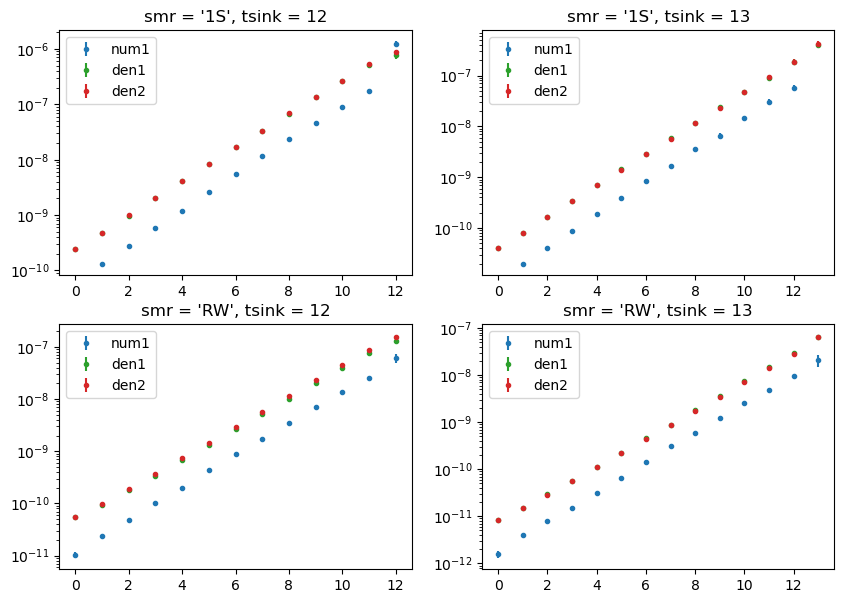

In [56]:
fig,ax = plt.subplots(2,2,figsize=(10,7))

data_read = {}
for i,smr in enumerate(['1S','RW']):
    data_read[smr] = {}
    for j,tsink in enumerate([Ta,Tb]):
        print(f'------------- {tsink = } --------- {smr = } -------------------')

        # Numerator 1
        corr = RatioFileString('P5_A4_V1_',tsink,heavy,smr,qq,light,mom)
        num1 = jkCorr(data[corr][:,:(tsink+1)], bsize=jk)
        print(corr)        
        print(format(num1))
        
        # Denominator 1
        corr = RatioFileString('P5_A2_V2_',tsink,heavy,smr,qq,light,mom)
        den1 = jkCorr(-data[corr][:,:(tsink+1)], bsize=jk)
        print(corr)        
        
        corr = RatioFileString('P5_A3_V3_',tsink,heavy,smr,qq,light,mom)
        den2 = jkCorr(-data[corr][:,:(tsink+1)], bsize=jk)
        print(corr)        
        
        r = num1 / ((den1 + den2)/2)
        data_read[smr][tsink] = r

        v = format(num1)
        ax[i,j].errorbar(np.arange(len(v)),gv.mean(v),gv.sdev(v),fmt='.',label='num1',color='C0')
        v = format(den1)
        ax[i,j].errorbar(np.arange(len(v)),gv.mean(v),gv.sdev(v),fmt='.',label='den1',color='C2')
        v = format(den2)
        ax[i,j].errorbar(np.arange(len(v)),gv.mean(v),gv.sdev(v),fmt='.',label='den2',color='C3')

        ax[i,j].set_title(f'{smr = }, {tsink = }')
        ax[i,j].set_yscale('log')
        ax[i,j].legend()

-------------- tsink = 12 smr = '1S' --------------
[-0.122(28) 0.274(15) 0.287(14) 0.293(17) 0.285(19) 0.316(21) 0.335(22)
 0.354(23) 0.346(24) 0.345(24) 0.341(24) 0.339(32) 1.52(23)]
13
-------------- tsink = 13 smr = '1S' --------------
[-0.067(30) 0.243(21) 0.242(21) 0.256(23) 0.273(25) 0.270(28) 0.287(30)
 0.294(29) 0.303(33) 0.279(37) 0.305(36) 0.331(40) 0.312(43) -0.16(14)]
14
-------------- tsink = 12 smr = 'RW' --------------
[0.188(26) 0.254(13) 0.266(14) 0.284(13) 0.281(14) 0.309(16) 0.326(17)
 0.320(19) 0.317(20) 0.321(21) 0.319(20) 0.310(25) 0.436(93)]
13
-------------- tsink = 13 smr = 'RW' --------------
[0.184(32) 0.260(16) 0.275(18) 0.270(19) 0.282(20) 0.297(22) 0.324(23)
 0.353(26) 0.336(28) 0.346(33) 0.350(29) 0.343(29) 0.334(34) 0.329(99)]
14


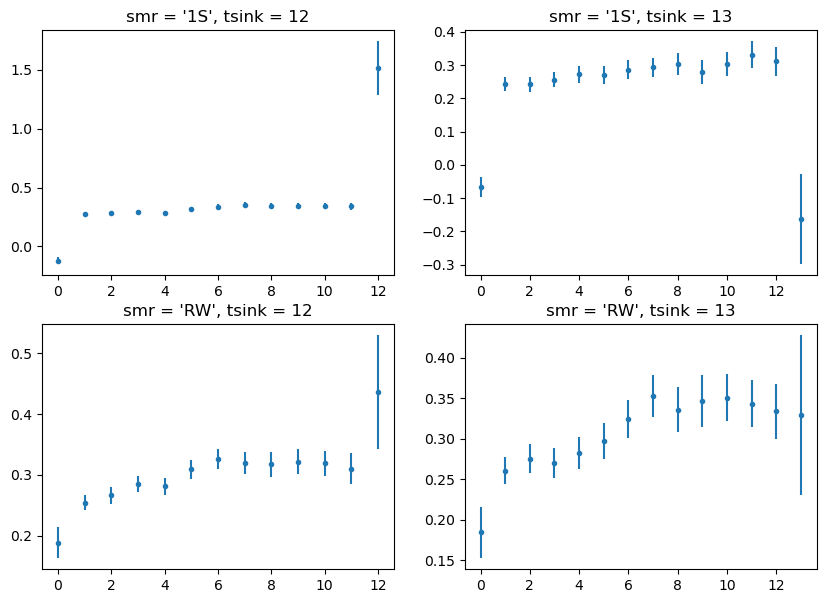

In [57]:
fig,ax = plt.subplots(2,2,figsize=(10,7))
for i,smr in enumerate(data_read):
    for j,tsink in enumerate(data_read[smr]):
        print(f'-------------- {tsink = } {smr = } --------------')
        print(format(data_read[smr][tsink]))
        print(len(format(data_read[smr][tsink])))

        v = format(data_read[smr][tsink])
        ax[i,j].errorbar(np.arange(len(v)),gv.mean(v),gv.sdev(v),fmt='.',label='num1',color='C0')
        ax[i,j].set_title(f'{smr = }, {tsink = }')

## Build correction factor

In the following cell we build the correction factor
$$\frac{Z_{D^*_a}(\mathbf p_\perp)}{\sqrt{Z_{D^*_a}(0)Z_{D_{1S}^*}(0)}} \frac{{M_{D^*}}^2}{{E^2_{D^*}}(\mathbf p)}$$

In [58]:
# This cell has only to be evaluated if next python cell is not

from b2heavy.ThreePointFunctions.types3pts import ratio_prerequisites

# frm = '/Users/pietro/code/data_analysis/data/QCDNf2p1stag/B2heavy/lattice24_old'
frm = '/Users/pietro/Desktop/lattice24/0.25/corr2_3'
req = ratio_prerequisites(ens,'RA1',mom,readfrom=frm)
req

{'E0': 1.179682175085136,
 'm0': 1.0809632444217314,
 'Z0': {'1S': 4.822281482026914, 'd': 0.04150728444106053},
 'Zpar': {'1S': 1.6320372022086296, 'd': 0.033818481030701474},
 'Zbot': {'1S': 1.1536983427438878, 'd': 0.02595700174869827},
 'Zp': {'1S': None, 'd': None},
 'wrecoil': 1.1126285207974154,
 'jk': False}

Fill the following cells with appropriate values

In [59]:
# req = {
#     'E0': 1.179682175085136,
#     'm0': 1.0809632444217314,
#     'Z0':   {'1S': 4.822281482026914, 'd': 0.04150728444106053},
#     'Zpar': {'1S': 1.6320372022086296, 'd': 0.033818481030701474},
#     'Zbot': {'1S': 1.1536983427438878, 'd': 0.02595700174869827},
# }

In [60]:
factor = {
    '1S': 1/np.sqrt(req['Zbot']['1S']/req['Zpar']['1S']), # (req['m0']/req['E0'])**2,
    'RW': 1/np.sqrt(req['Zbot']['d' ]/req['Zpar']['d' ]), # (req['m0']/req['E0'])**2,
}

factor

{'1S': 1.189375238551202, 'RW': 1.1414313208756592}

here we divide the data that we read by the correction factor

In [61]:
data_corr = {smr: {} for smr in data_read}

for smr in data_read:
    for tsink in data_read[smr]:
        data_corr[smr][tsink] = data_read[smr][tsink][:,:Ta+1] / factor[smr]
        print(f'-------------- {tsink = } {smr = } --------------')
        print(format(data_corr[smr][tsink]))

-------------- tsink = 12 smr = '1S' --------------
[-0.103(24) 0.230(13) 0.241(12) 0.246(14) 0.240(16) 0.266(18) 0.281(18)
 0.297(19) 0.291(20) 0.290(20) 0.287(20) 0.285(27) 1.27(19)]
-------------- tsink = 13 smr = '1S' --------------
[-0.056(25) 0.205(17) 0.203(18) 0.215(19) 0.229(21) 0.227(24) 0.241(25)
 0.247(24) 0.254(28) 0.235(31) 0.256(31) 0.279(34) 0.262(36)]
-------------- tsink = 12 smr = 'RW' --------------
[0.165(22) 0.223(11) 0.233(12) 0.249(12) 0.247(12) 0.271(14) 0.285(14)
 0.280(16) 0.278(18) 0.282(18) 0.280(18) 0.271(22) 0.382(82)]
-------------- tsink = 13 smr = 'RW' --------------
[0.161(28) 0.228(14) 0.241(16) 0.236(16) 0.247(17) 0.260(19) 0.284(20)
 0.309(22) 0.294(24) 0.303(28) 0.307(25) 0.301(25) 0.292(29)]


## Exponentials + smoothening

$$
\bar R_{A_1}(t,T) = \frac{1}{2}R_{A_1}(t,T) + \frac{1}{4}R_{A_1}(t,T+1)  + \frac{1}{4}R_{A_1}(t+1,T+1) 

In [62]:
barR = {}
barR['1S'] = data_corr['1S'][Ta  ]/2 +     data_corr['1S'][Tb]/4 +  np.roll(data_corr['1S'][Tb],-1,axis=1)/4
barR['RW'] = data_corr['RW'][Ta  ]/2 +     data_corr['RW'][Tb]/4 +  np.roll(data_corr['RW'][Tb],-1,axis=1)/4

In [63]:
for sm in ['1S','RW']:
    print(f'------------ {sm = } -------------')
    print(format(barR[sm]))

------------ sm = '1S' -------------
[-0.014(14) 0.217(11) 0.225(12) 0.234(13) 0.234(15) 0.250(16) 0.263(16)
 0.274(18) 0.268(20) 0.268(20) 0.277(20) 0.278(24) 0.688(94)]
------------ sm = 'RW' -------------
[0.180(15) 0.229(10) 0.236(11) 0.245(11) 0.250(11) 0.271(12) 0.291(14)
 0.291(16) 0.288(17) 0.293(17) 0.292(15) 0.284(18) 0.305(41)]


<ErrorbarContainer object of 3 artists>

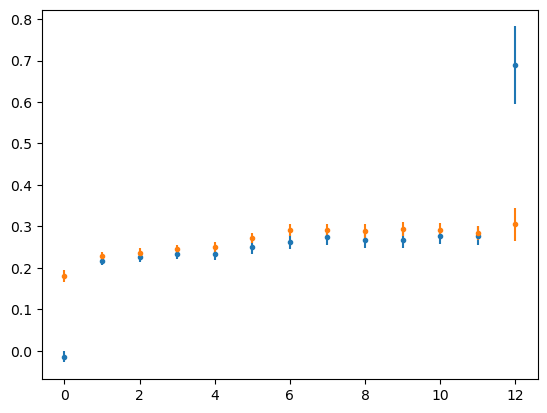

In [64]:
y1S = format(barR['1S'])
yRW = format(barR['RW'])
x   = np.arange(len(y1S))

plt.errorbar(x,gv.mean(y1S),gv.sdev(y1S),fmt='.')
plt.errorbar(x,gv.mean(yRW),gv.sdev(yRW),fmt='.')

# `CUSTOM`

In [65]:
from b2heavy.ThreePointFunctions.types3pts  import Ratio, RatioIO, ratio_prerequisites
from b2heavy.ThreePointFunctions.fitter3pts import RatioFitter, phys_energy_priors
from b2heavy.ThreePointFunctions.utils      import read_config_fit, dump_fit_object
from b2heavy.ThreePointFunctions.corr3pts   import BINSIZE

In [66]:
DATA_DIR = '/Users/pietro/code/data_analysis/BtoD/Alex/'
io = RatioIO(ens,'R0',mom,PathToDataDir=DATA_DIR)
robj = RatioFitter(
    io,
    jkBin     = BINSIZE[ens],
    smearing  = ['1S','RW'],
    **req
)

In [67]:
robj.format()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 {'1S': array([-0.014(14), 0.217(11), 0.225(12), 0.234(13), 0.234(15), 0.250(16),
         0.263(17), 0.274(18), 0.268(20), 0.268(20), 0.277(20), 0.278(24),
         0.688(94)], dtype=object),
  'RW': array([0.180(15), 0.229(10), 0.236(11), 0.245(11), 0.250(11), 0.271(12),
         0.291(14), 0.291(16), 0.288(17), 0.293(17), 0.292(15), 0.284(18),
         0.305(41)], dtype=object)})

In [68]:
x,rr = robj.format()
r1S = rr['1S']
rRW = rr['RW']

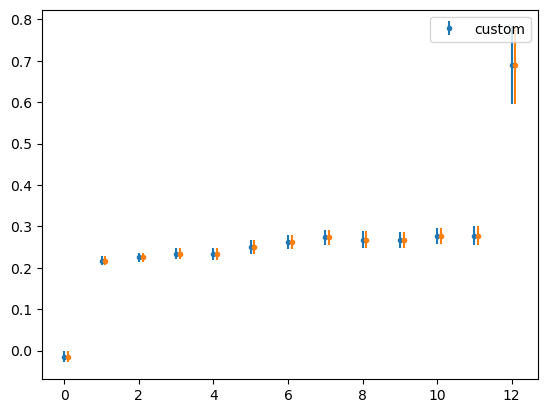

In [69]:
plt.errorbar(x,gv.mean(r1S),gv.sdev(r1S),fmt='.',label='custom')
plt.errorbar(x+0.1,gv.mean(y1S),gv.sdev(y1S),fmt='.')
plt.legend()

<ErrorbarContainer object of 3 artists>

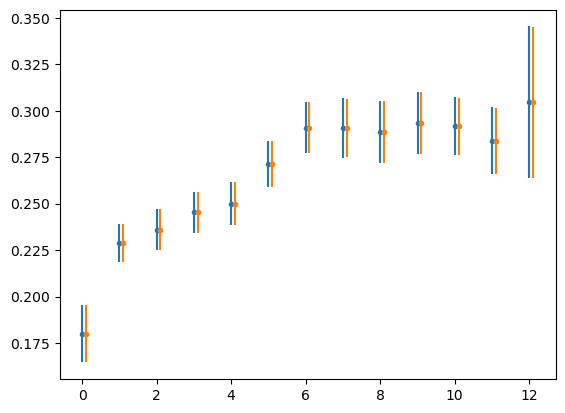

In [70]:
plt.errorbar(x    ,gv.mean(rRW),gv.sdev(rRW),fmt='.')
plt.errorbar(x+0.1,gv.mean(yRW),gv.sdev(yRW),fmt='.')